In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt
import math

/tmp/ipykernel_300339/1518451047.py:8: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("ignore", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [3]:
with open('../../filelists/300to470_files.txt', 'r') as f:
    qcd_files = [line.strip() for line in f]

In [4]:
qcd = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/qcd/300to470/' + qcd_files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "300to470"},
).events()

In [367]:
#color ring
def color_ring(fatjet, cluster_val):
    pf = ak.flatten(fatjet.constituents.pf, axis=1)
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, cluster_val)
    cluster = fastjet.ClusterSequence(pf, jetdef)
    #subjets = cluster.exclusive_jets(n_jets=3)
    subjets = cluster.inclusive_jets()
    vec = ak.zip(
        {
            "x": subjets.px,
            "y": subjets.py,
            "z": subjets.pz,
            "t": subjets.E,
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    vec = ak.pad_none(vec, 3)
    vec["norm3"] = np.sqrt(vec.dot(vec))
    vec["idx"] = ak.local_index(vec)
    i, j, k = ak.unzip(ak.combinations(vec, 3))
    #best = ak.argmin(abs((i + j + k).mass - 125), axis=1, keepdims=True)
    best = ak.argmax(abs((i + j + k).mass), axis=1, keepdims=True)
    order_check = ak.concatenate([i[best].mass, j[best].mass, k[best].mass], axis=1)
    largest = ak.argmax(order_check, axis=1, keepdims=True)
    smallest = ak.argmin(order_check, axis=1, keepdims=True)
    leading_particles = ak.concatenate([i[best], j[best], k[best]], axis=1)
    leg1 = leading_particles[largest]
    leg3 = leading_particles[smallest]
    leg2 = leading_particles[
        (leading_particles.idx != ak.flatten(leg1.idx))
        & (leading_particles.idx != ak.flatten(leg3.idx))
    ]
    leg1 = ak.firsts(leg1)
    leg2 = ak.firsts(leg2)
    leg3 = ak.firsts(leg3)
    
    # a12 = np.arccos(leg1.dot(leg2) / (leg1.norm3 * leg2.norm3))
    # a13 = np.arccos(leg1.dot(leg3) / (leg1.norm3 * leg3.norm3))
    # a23 = np.arccos(leg2.dot(leg3) / (leg2.norm3 * leg3.norm3))
    # color_ring = (a13**2 + a23**2) / (a12**2)

    a12 = leg1.delta_r2(leg2)
    a13 = leg1.delta_r2(leg3)
    a23 = leg2.delta_r2(leg3)
    color_ring = (a13 + a23) / (a12)
    
    return ak.Array({"cr":color_ring, "hp0_eta":leg1.eta, "hp1_eta":leg2.eta, "se_eta":leg3.eta,
                    "hp0_phi":leg1.phi, "hp1_phi":leg2.phi, "se_phi":leg3.phi,
                    "hp0_pt":leg1.pt, "hp1_pt":leg2.pt, "se_pt":leg3.pt})

In [368]:
fatjet = qcd.FatJet[(qcd.FatJet.pt == ak.max(qcd.FatJet.pt, axis=1))]

In [369]:
cr_arr = color_ring(fatjet, cluster_val=0.2) #output color ring and chosen subjets
uf_cr = ak.unflatten(cr_arr['cr'], counts=ak.num(fatjet)) #unflatten color ring to  event structure
uf_hp0_eta = ak.unflatten(cr_arr['hp0_eta'], counts=ak.num(fatjet))
uf_hp0_phi = ak.unflatten(cr_arr['hp0_phi'], counts=ak.num(fatjet))
uf_hp0_pt = ak.unflatten(cr_arr['hp0_pt'], counts=ak.num(fatjet))
uf_hp1_eta = ak.unflatten(cr_arr['hp1_eta'], counts=ak.num(fatjet))
uf_hp1_phi = ak.unflatten(cr_arr['hp1_phi'], counts=ak.num(fatjet))
uf_hp1_pt = ak.unflatten(cr_arr['hp1_pt'], counts=ak.num(fatjet))
uf_se_eta = ak.unflatten(cr_arr['se_eta'], counts=ak.num(fatjet))
uf_se_phi = ak.unflatten(cr_arr['se_phi'], counts=ak.num(fatjet))
uf_se_pt = ak.unflatten(cr_arr['se_pt'], counts=ak.num(fatjet))

In [370]:
all_vals = ak.zip({'cr':uf_cr,
        'hp0_eta':uf_hp0_eta, 'hp0_phi':uf_hp0_phi, 'hp0_pt':uf_hp0_pt,
        'hp1_eta':uf_hp1_eta, 'hp1_phi':uf_hp1_phi, 'hp1_pt':uf_hp1_pt,
        'se_eta':uf_se_eta, 'se_phi':uf_se_phi, 'se_pt':uf_se_pt,
       'idx':np.linspace(0, len(fatjet)-1, len(fatjet), dtype='int'),
                  })

In [417]:
choose = 5
hp0_eta = all_vals['hp0_eta'][choose][0]
hp1_eta = all_vals['hp1_eta'][choose][0]
se_eta = all_vals['se_eta'][choose][0]
hp0_phi = all_vals['hp0_phi'][choose][0]
hp1_phi = all_vals['hp1_phi'][choose][0]
se_phi = all_vals['se_phi'][choose][0]

In [418]:
pfcands_eta = fatjet.constituents.pf.eta[choose][(abs(fatjet.constituents.pf.eta[choose]) < 2.5) & (abs(fatjet.constituents.pf.phi[choose]) < 1)]
pfcands_phi = fatjet.constituents.pf.phi[choose][(abs(fatjet.constituents.pf.eta[choose]) < 2.5) & (abs(fatjet.constituents.pf.phi[choose]) < 1)]

In [431]:
genpart = qcd.GenPart[qcd.GenPart.hasFlags(['fromHardProcess', 'isPrompt'])]
# genpart_eta = genpart.eta[choose][(abs(genpart.eta[choose]) < 10) & (abs(genpart.phi[choose]) < 10)]
# genpart_phi = genpart.phi[choose][(abs(genpart.eta[choose]) < 10) & (abs(genpart.phi[choose]) < 10)]
genpart_eta = genpart.eta[choose][(abs(genpart.eta[choose]) < 2.5) & (abs(genpart.phi[choose]) < 3)]
genpart_phi = genpart.phi[choose][(abs(genpart.eta[choose]) < 2.5) & (abs(genpart.phi[choose]) < 3)]

In [432]:
midpoint_eta = (hp0_eta + hp1_eta)/2
midpoint_phi = (hp0_phi + hp1_phi)/2

Text(0.5, 1.0, 'QCD Jet')

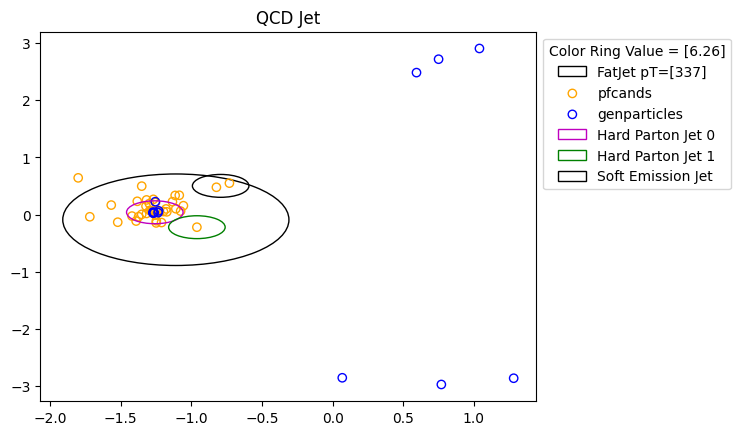

In [433]:
#First gen children and the selected subjets
fig,ax = plt.subplots()
# ax.add_patch(plt.Circle((parent.eta, parent.phi), 0.8, facecolor="none", edgecolor="k", label="AK8 Jet"))
# ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
# ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8*radius, facecolor='none', edgecolor='r', linestyle='--'))
# ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.6*radius, facecolor='none', edgecolor='r', linestyle='--'))
# ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.4*radius, facecolor='none', edgecolor='r', linestyle='--'))
# ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.2*radius, facecolor='none', edgecolor='r', linestyle='--'))
# ax.scatter(parent.children[0].eta, parent.children[0].phi, 
#            #s=higgs.children[0].pt, 
#            label="B Quark 0", color='m')
# ax.scatter(parent.children[1].eta, parent.children[1].phi, 
#            #s=higgs.children[1].pt, 
#            label="B Quark 1", color='g')
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8, facecolor='none', edgecolor='k', label=f"FatJet pT={fatjet[choose].pt}"))
ax.scatter(pfcands_eta, pfcands_phi, 
#            #s=glu_pt, 
            marker="o", color='orange', label='pfcands',facecolors='none')
ax.scatter(genpart_eta, genpart_phi, 
#            #s=glu_pt, 
            marker="o", color='blue', label='genparticles',facecolors='none')
ax.add_patch(plt.Circle((hp0_eta, hp0_phi), 0.2, facecolor='none', edgecolor='m', label='Hard Parton Jet 0'))
ax.add_patch(plt.Circle((hp1_eta, hp1_phi), 0.2, facecolor='none', edgecolor='g', label='Hard Parton Jet 1'))
ax.add_patch(plt.Circle((se_eta, se_phi), 0.2, facecolor='none', edgecolor='k', label='Soft Emission Jet'))

lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(all_vals['cr'][choose]))
plt.title('QCD Jet')

In [434]:
all_vals['hp0_eta'][choose]

<Array [-1.26] type='1 * ?float64'>